In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from tqdm import tqdm
from torch.nn import functional as F
from context_compression.model import GPT, GPTConfig
from context_compression.attn import AttentionKind
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = 'out' # ignored if init_from is not 'resume'
start = "Hello, I'm a language model," # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 10 # number of samples to draw
max_new_tokens = 256 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# init from a model saved in a specific directory

def mup_GPT(config):
    model = GPT(config)
    base_config = GPTConfig(**{**config.__dict__, "n_head": 12, "head_dim": 64, "n_embd": 64*12, "mup": True})
    base_model = GPT(base_config)
    from mup import set_base_shapes
    set_base_shapes(model, base_model)
    return model

from huggingface_hub import hf_hub_download

# model = GPT(GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304))
# ckpt_path = "/workspace/context-compression/selective_run_0_continued/model_09999.pt"

# model = GPT(GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304))
# ckpt_path = "/workspace/context-compression/selective_run_0_continued/model_09999.pt"

# model = GPT(GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False, vocab_size=50304))
# ckpt_path = "/workspace/context-compression/memory_loss_run_0/model_09999.pt"

# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False, vocab_size=50304,disable_selection=True)
# model = GPT(config)
# ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="unselective_run_0/model_09999.pt")

# model = GPT(GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False, vocab_size=50304))
# ckpt_path = "/root/.cache/huggingface/hub/models--Yorth--selective1/snapshots/1d3d987c90be4b8d6f58de60749ba5823f0ecd29/model.pt"

# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304,n_head=13)
# model = GPT(config)
# ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="self_to_selective_run_0_restarted/model_02499.pt")
# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304,n_head=13)
# ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="protection_none_torch_compile/model_02499.pt")
# new_eps_ratios, new_eps_losses = get_validation_loss_at_diff_ratios(new_config, ckpt_path)

# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False, vocab_size=50304)
# model = GPT(config)
# ckpt_path = hf_hub_download(repo_id="Yorth/selective1",filename="model.pt")

# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False,n_head=12,head_dim=22,n_embd=22*12,block_size=256,mup=True)
# model = mup_GPT(config)
# ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="12_head_baseline_lr_30e-4_head_dim_22_fixed/model_04374.pt")

from context_compression.attn import SelectionHeadLinearComboKind
# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False,n_head=12,head_dim=22,n_embd=22*12,block_size=256,mup=True,selection_head_linear_combo=SelectionHeadLinearComboKind.N_LATENT_MASKS,n_latent_masks=1)
# model = mup_GPT(config)
# ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="logs/repro_selective_pattern_rankings/12_mini_head_one_mask_per_head_1_latent_mask_10e-4_seed_1339/model_04374.pt")

# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False,n_head=12,head_dim=22,n_embd=22*12,block_size=256,mup=True,selection_head_linear_combo=SelectionHeadLinearComboKind.N_LATENT_MASKS,n_latent_masks=1)
# model = mup_GPT(config)
# ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="logs/fix_1_latent_mask/1_latent_mask_lr_30e-4_scale_0.125_seed_1339/model_04374.pt")

# clamped-to-identity 1 latent mask. so should have no variation
# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False,n_head=12,head_dim=22,n_embd=22*12,block_size=256,mup=True,selection_head_linear_combo=SelectionHeadLinearComboKind.N_LATENT_MASKS,n_latent_masks=1,disable_selection_head_linear_combo_bias=True)
# model = mup_GPT(config)
# ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="logs/fix_1_latent_mask/1_latent_mask_lr_30e-4_lr_scale_0_seed_1339_no_compile/model_04374.pt")

# # stable training 1 latent mask. I hope it's p sparse!
# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False,n_head=12,head_dim=22,n_embd=22*12,block_size=256,mup=True,selection_head_linear_combo=SelectionHeadLinearComboKind.N_LATENT_MASKS,n_latent_masks=1)
# model = mup_GPT(config)
# ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="logs/fix_1_latent_mask/1_latent_mask_lr_30e-4_seed_1339_no_compile/model_04374.pt")

# baseline (no latent masks)
# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False,n_head=12,head_dim=22,n_embd=22*12,block_size=256,mup=True)
# model = mup_GPT(config)
# ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="logs/fix_1_latent_mask/baseline_lr_30e-4_seed_1339_no_compile/model_04374.pt")

config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False,n_head=12,head_dim=22,n_embd=22*12,block_size=256,mup=True,selection_head_linear_combo=SelectionHeadLinearComboKind.N_LATENT_MASKS,n_latent_masks=2)
model = mup_GPT(config)
ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="logs/fix_1_latent_mask/1_latent_mask_lr_30e-4_n_latent_masks_2_seed_1339/model_04374.pt")

checkpoint = torch.load(ckpt_path, map_location=device)

state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict,strict=False)


model_04374.pt:   0%|          | 0.00/97.7M [00:00<?, ?B/s]

/tmp/ipykernel_4765/803871655.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


<All keys matched successfully>

In [2]:
# Tokenize input text using GPT-2 tokenizer
enc = tiktoken.get_encoding("gpt2")
text = "the real problem with traditional dental veneers has little to do with how they function or their performance . who determines what a normal , aesthetically pleasing smile looks like is the real issue . america struggled for decades with defining “ image ” as a marketplace bent on exploiting peoples ’ flaws for economic gain . the danger of this national obsession has become systemic since the days of twiggy . fashion magazines offer photoshopped perfection as the standard to which we should aspire . the effects of this insidious marketing made their way into breast implants and the definition of a hollywood smile . carving their bodies and their teeth , people use their resources to chase a false picture of their “ perfect ” self . people make investments in the tens of thousands of dollars at their dentist office to get the “ perfect ” smile . this message has become so endemic that people with nice smiles are convinced only a “ perfect ” hollywood smile is acceptable . one particularly relevant example of this is highlighted in a june 2015 article entitled “ saving jane ’ s smile . ” gary nankin , dds discusses how he “ saved ” the smile of a patient who was not content with her first set of # porcelain veneers . 1 . endodontic referral for treatment of tooth number 15 , followed by a composite core build - up . 2 . periodontal therapy in both the anterior region and upper left to achieve optimal tissue health . 4 . preparation of maxillary teeth and placement of permanent restorations . 5 . placement of dental implant by the periodontist followed by preparation of mandibular teeth and placement of permanent restorations . 6 .  restore the now fully - healed and osseointegrated implant in the position of tooth number 30 . regarding a person ’ s smile , the strong link to self - esteem and self - worth make an imperfect set of teeth a concern . however , the picture in the article clearly illustrates what appears to be a well - constructed and healthy - looking smile . the entire premise is puzzling . how does a dentist promote “ saving ” a smile that 97 % of the people in america would love to show off ? "
tokens = enc.encode(text)[:256]
tokens = torch.tensor(tokens).unsqueeze(0).to(device) # Add batch dimension and move to device
y = torch.roll(tokens, -1, dims=1)
y[:,-1] = -100

ff_cache = []

model.to(device)

# Run through model
with torch.no_grad():
    with ctx:
        logits, loss, losses = model(tokens,y,ff_cache=ff_cache)
        
print(f"Output logits shape: {logits.shape}")
print("Loss:", loss)


Output logits shape: torch.Size([1, 256, 50257])
Loss: tensor(4.8137, device='cuda:0')


In [ ]:
enc.decode(tokens[0,130:165].tolist())

' chase a false picture of their “ perfect ” self . people make investments in the tens of thousands of dollars at their dentist office to get the “ perfect ”'

12 256 256
Mean mask value: 121.4739
Std dev of mask values: 326.9247


/tmp/ipykernel_4765/961586037.py:57: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  att_matrix = torch.nn.functional.softmax(att_tensor - mask, dim=-1)
/tmp/ipykernel_4765/961586037.py:63: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  rgba_image[:, :, 3] = opacity_matrix


Number of total head-tokens kept: 13439 / 36864 (36.46%)


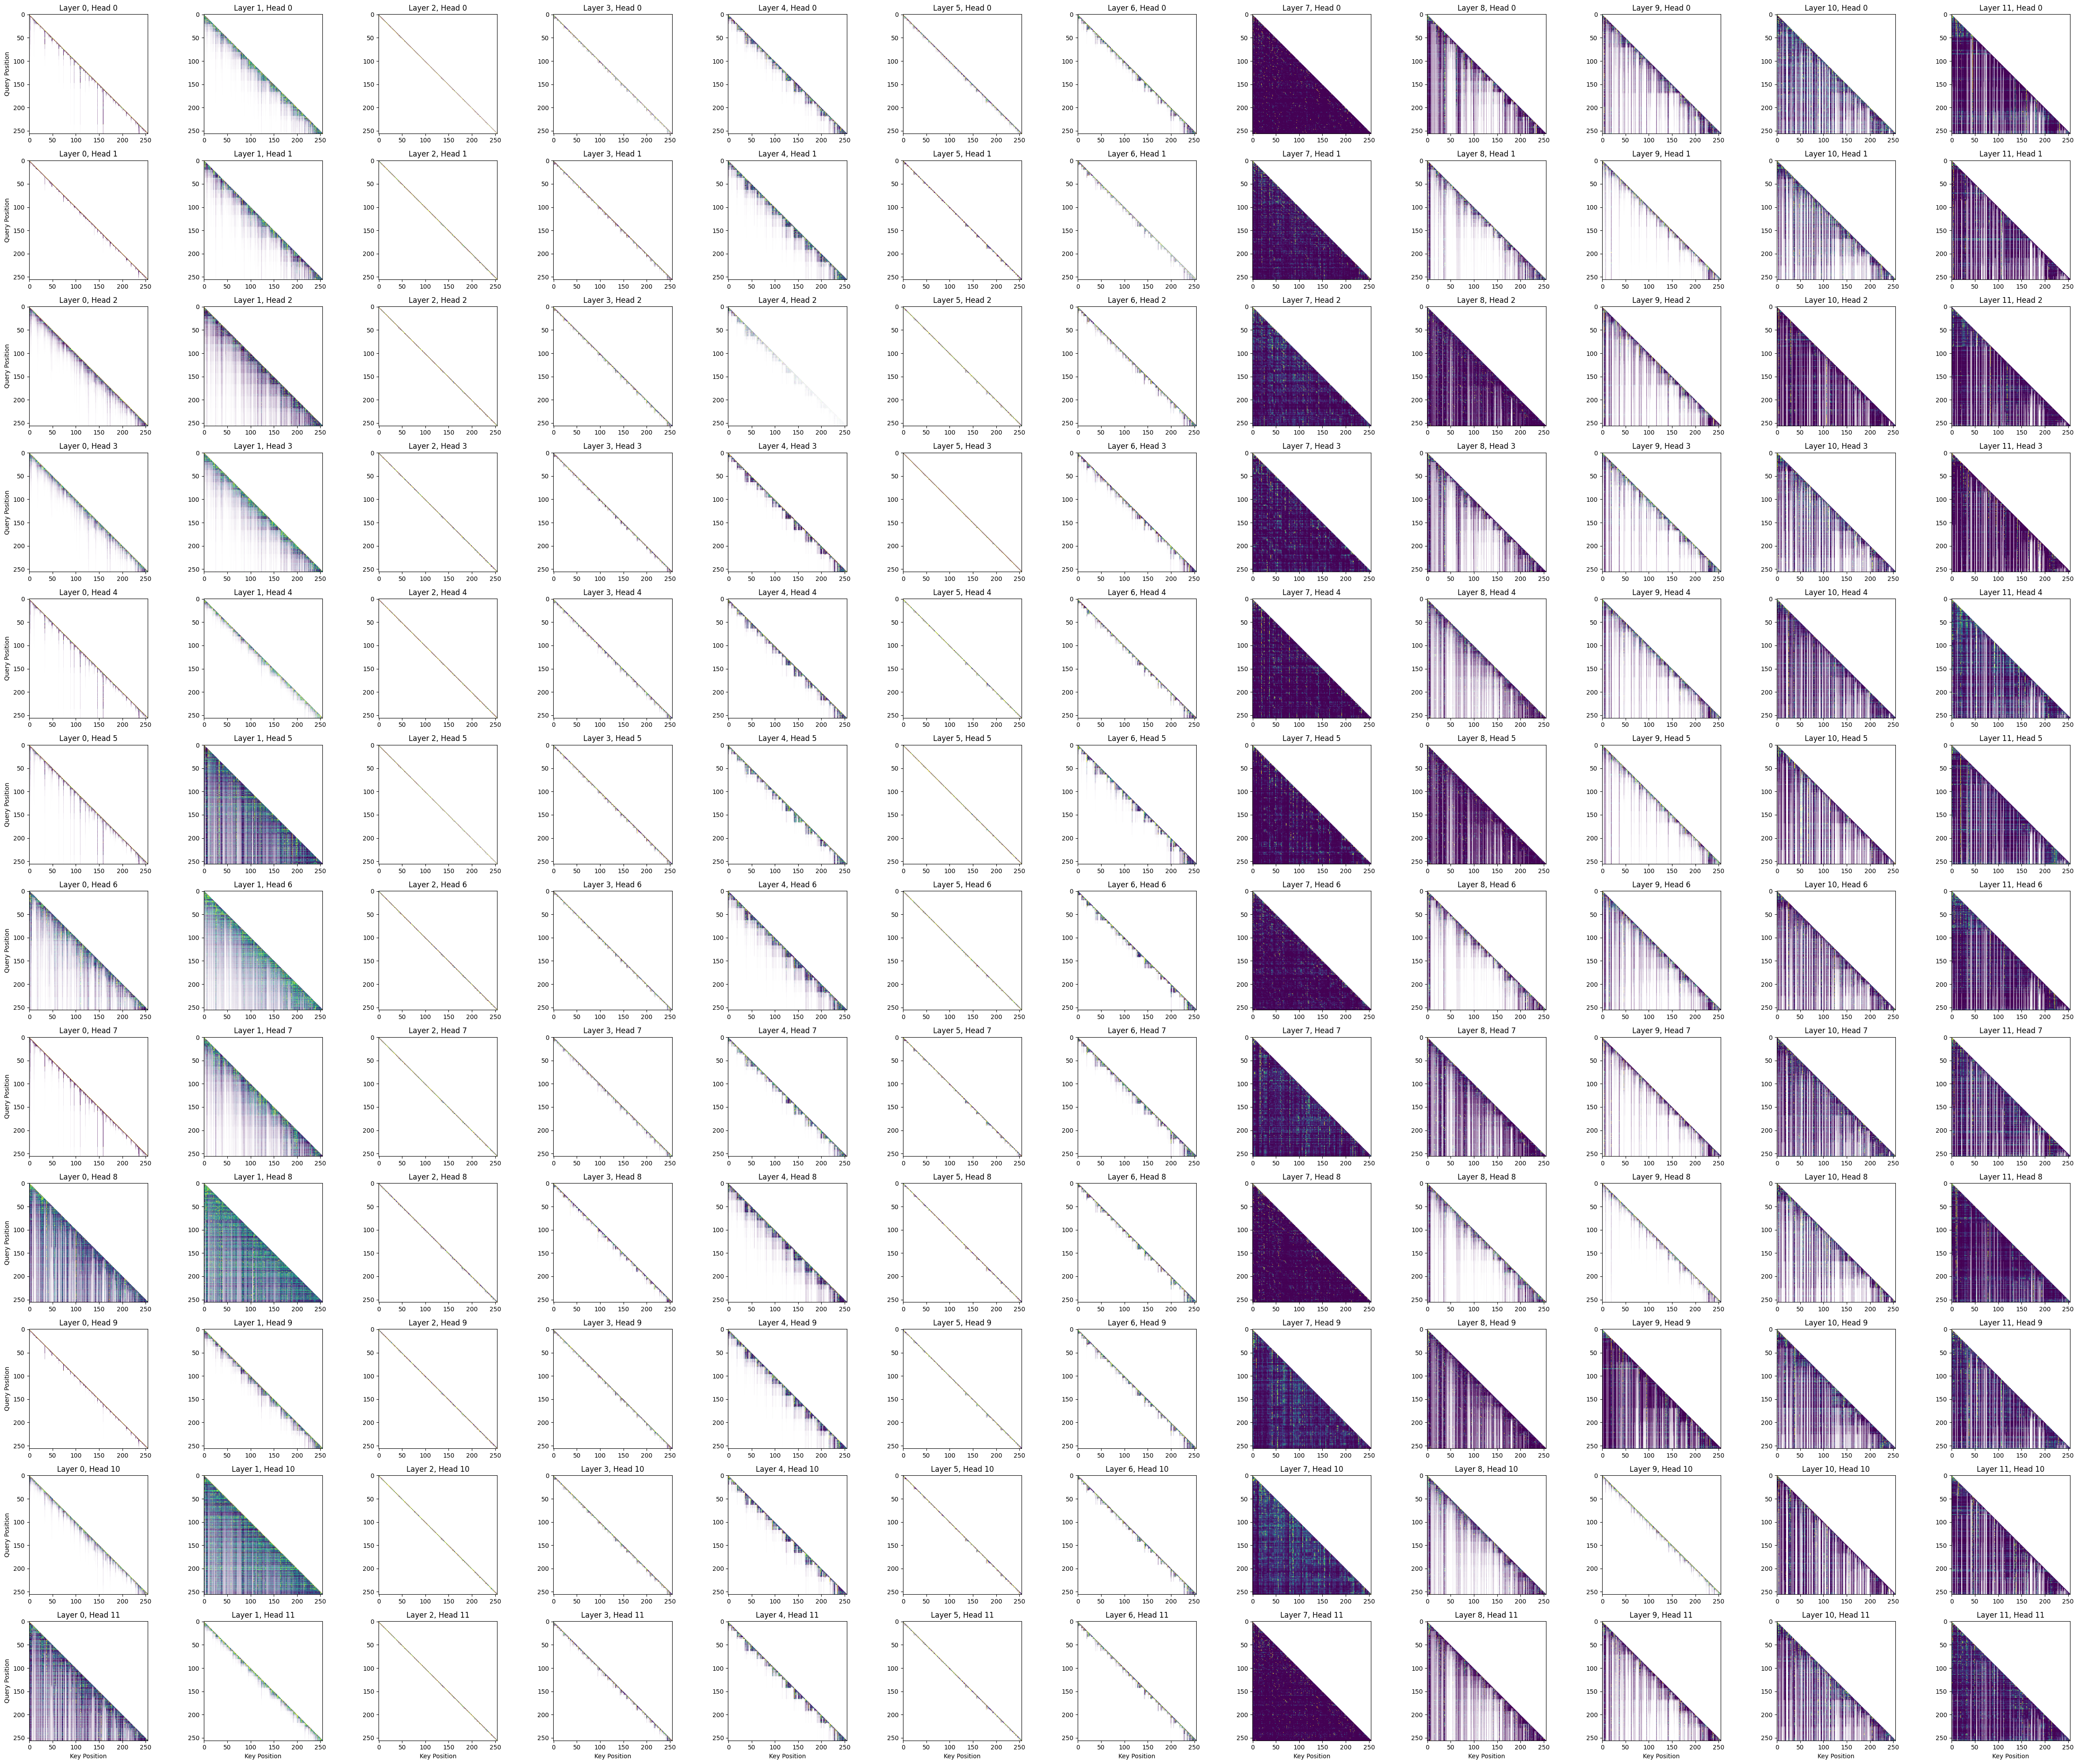

In [4]:
nh,T,Tp = ff_cache[0][0].squeeze(0).shape
print(nh,T,Tp)

# Plot the attention masks as a bitmap
import matplotlib.pyplot as plt

# Take the first layer's mask from the first batch
mask = ff_cache[6][0].squeeze(0)  # Shape: [T,Tp]

# plt.figure(figsize=(10,10))
# plt.imshow(-mask, cmap='viridis', aspect='equal')
# plt.colorbar(label='Mask Value')
# plt.title('Attention Mask')
# plt.xlabel('Key Position')
# plt.ylabel('Query Position') 
# plt.show()
import numpy as np

# Calculate mean and standard deviation across all layers
all_masks = np.array([layer_mask[0][0,0,-1] for layer_mask in ff_cache])
mean_mask = np.mean(all_masks)
std_mask = np.std(all_masks)
print(f"Mean mask value: {mean_mask:.4f}")
print(f"Std dev of mask values: {std_mask:.4f}")

import matplotlib.colors as mcolors

# Create a custom colormap that goes from white (for 0) to light green (for 3)
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_white_lightgreen", ["white", "limegreen"])

# Use this colormap when displaying the mask, with vmin=0 and vmax=3

# # Optionally plot masks from all layers
n_layers_to_show = len(ff_cache)
n_heads_to_show = 12  # Now we have 12 heads per layer
fig, axes = plt.subplots(n_heads_to_show, n_layers_to_show, figsize=(4*n_layers_to_show, 10*n_heads_to_show/3))

num_to_keep = 0

for layer_idx, (layer_mask,att) in enumerate(ff_cache[:n_layers_to_show]):
    for head_idx in range(n_heads_to_show):
        mask = layer_mask[0, head_idx % layer_mask.shape[1],:,1:]  # Take first batch, head_idx head
        
        is_kept_mask = torch.ones_like(torch.tensor(mask))
        is_kept_mask[torch.triu(torch.ones_like(torch.tensor(mask))) == 1] = 0
        is_kept_mask *= torch.exp(-1 * torch.tensor(mask))

        num_to_keep += (is_kept_mask[-1,:] > 0.05).sum()

        opacity_matrix = is_kept_mask

        # Convert to torch tensor if it's a numpy array
        if isinstance(att, np.ndarray):
            att_tensor = torch.tensor(att[0, head_idx % att.shape[1],:,1:])
        else:
            att_tensor = att[0, head_idx % att.shape[1],:,1:]
        att_matrix = torch.nn.functional.softmax(att_tensor - mask, dim=-1)
        att_matrix_with_row_wise_max_one = att_matrix / att_matrix.max(dim=-1,keepdim=True)[0]

        default_matplotlib_cmap = plt.cm.viridis

        rgba_image = default_matplotlib_cmap(att_matrix_with_row_wise_max_one)
        rgba_image[:, :, 3] = opacity_matrix

        axes[head_idx, layer_idx].imshow(rgba_image, aspect='equal')
        axes[head_idx, layer_idx].set_title(f'Layer {layer_idx}, Head {head_idx}')
        
        # Only add x-labels for the bottom row
        if head_idx == n_heads_to_show - 1:
            axes[head_idx, layer_idx].set_xlabel('Key Position')
        
        # Only add y-labels for the leftmost column
        if layer_idx == 0:
            axes[head_idx, layer_idx].set_ylabel('Query Position')

num_total = n_heads_to_show * T * len(ff_cache)
print(f"Number of total head-tokens kept: {num_to_keep} / {num_total} ({num_to_keep / num_total:.2%})")

plt.tight_layout()
plt.show()

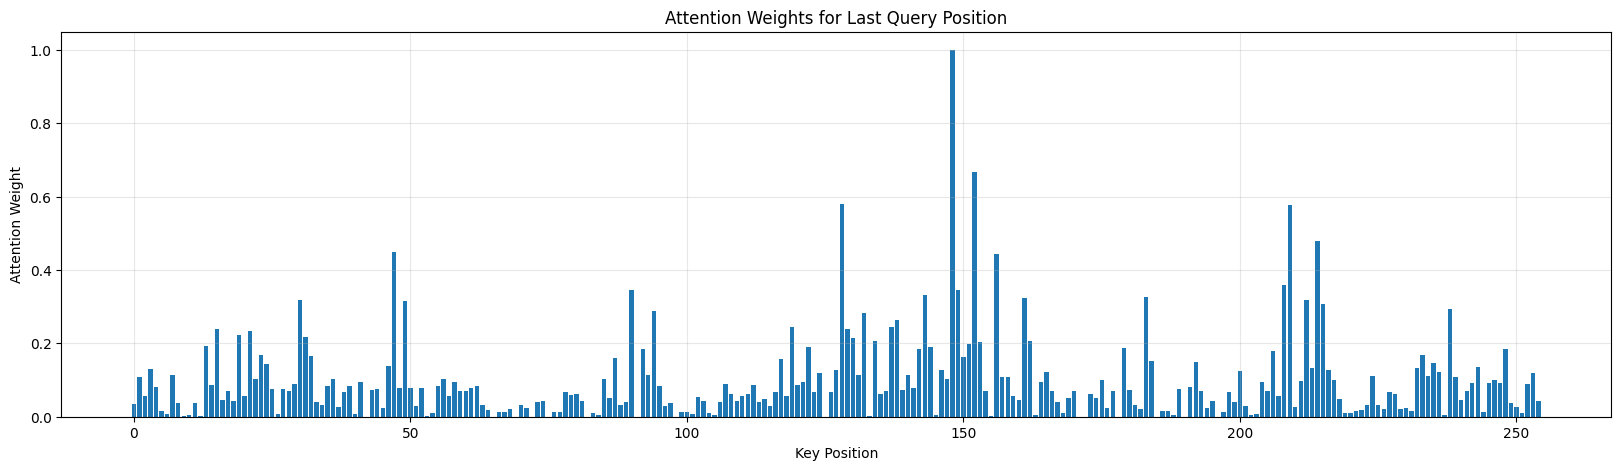

In [5]:
# Plot the attention weights for the last query position
plt.figure(figsize=(20, 5))
plt.bar(range(len(att_matrix_with_row_wise_max_one[-1])), att_matrix_with_row_wise_max_one[-1].cpu().numpy())
plt.xlabel('Key Position')
plt.ylabel('Attention Weight')
plt.title('Attention Weights for Last Query Position')
plt.grid(alpha=0.3)
plt.show()

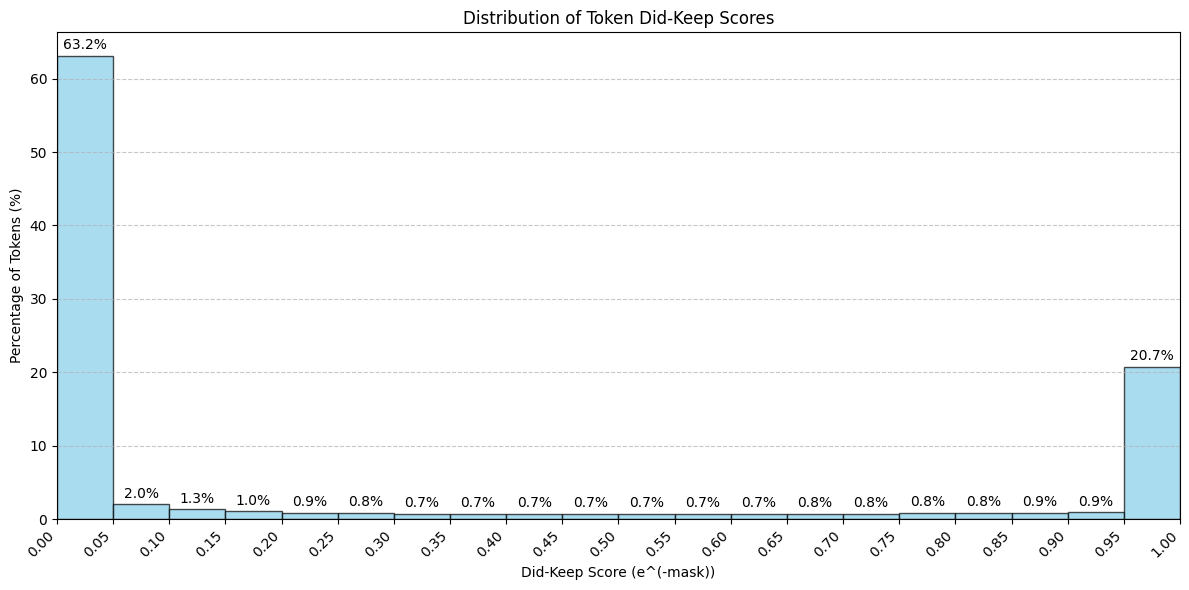

Mean did-keep score: 0.2812
Median did-keep score: 0.0000
Percentage of tokens with score > 0.5: 27.82%
Percentage of tokens with score < 0.1: 65.17%


In [6]:
# Create a histogram of token did-keep scores
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get the mask values from the last position of each layer
all_mask_values = []
for layer_idx, (layer_mask,_) in enumerate(ff_cache):
    for head_idx in range(n_heads_to_show):
        # Get the last row (query) for each head
        mask = layer_mask[0, head_idx % layer_mask.shape[1], -1, :]
        # Convert to did-keep scores: e^(-mask)
        did_keep_scores = torch.exp(-1 * torch.tensor(mask))
        all_mask_values.extend(did_keep_scores.numpy())

# Convert to numpy array for easier manipulation
all_mask_values = np.array(all_mask_values)

# Create histogram
plt.figure(figsize=(12, 6))
bins = np.linspace(0, 1, 21)  # 20 bins from 0 to 1
counts, bin_edges = np.histogram(all_mask_values, bins=bins)
percentages = counts / len(all_mask_values) * 100

# Plot as a bar chart
plt.bar(bin_edges[:-1], percentages, width=0.05, align='edge', 
        color='skyblue', edgecolor='black', alpha=0.7)

# Add percentage labels on top of each bar
for i, percentage in enumerate(percentages):
    if percentage > 0:  # Only show labels for non-zero bars
        plt.text(bin_edges[i] + 0.025, percentage + 0.5, 
                 f'{percentage:.1f}%', ha='center', va='bottom')

plt.xlabel('Did-Keep Score (e^(-mask))')
plt.ylabel('Percentage of Tokens (%)')
plt.title('Distribution of Token Did-Keep Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0, 1)

# Add more detailed x-axis labels
plt.xticks(np.linspace(0, 1, 21), 
           [f'{x:.2f}' for x in np.linspace(0, 1, 21)],
           rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Mean did-keep score: {np.mean(all_mask_values):.4f}")
print(f"Median did-keep score: {np.median(all_mask_values):.4f}")
print(f"Percentage of tokens with score > 0.5: {np.mean(all_mask_values > 0.5) * 100:.2f}%")
print(f"Percentage of tokens with score < 0.1: {np.mean(all_mask_values < 0.1) * 100:.2f}%")



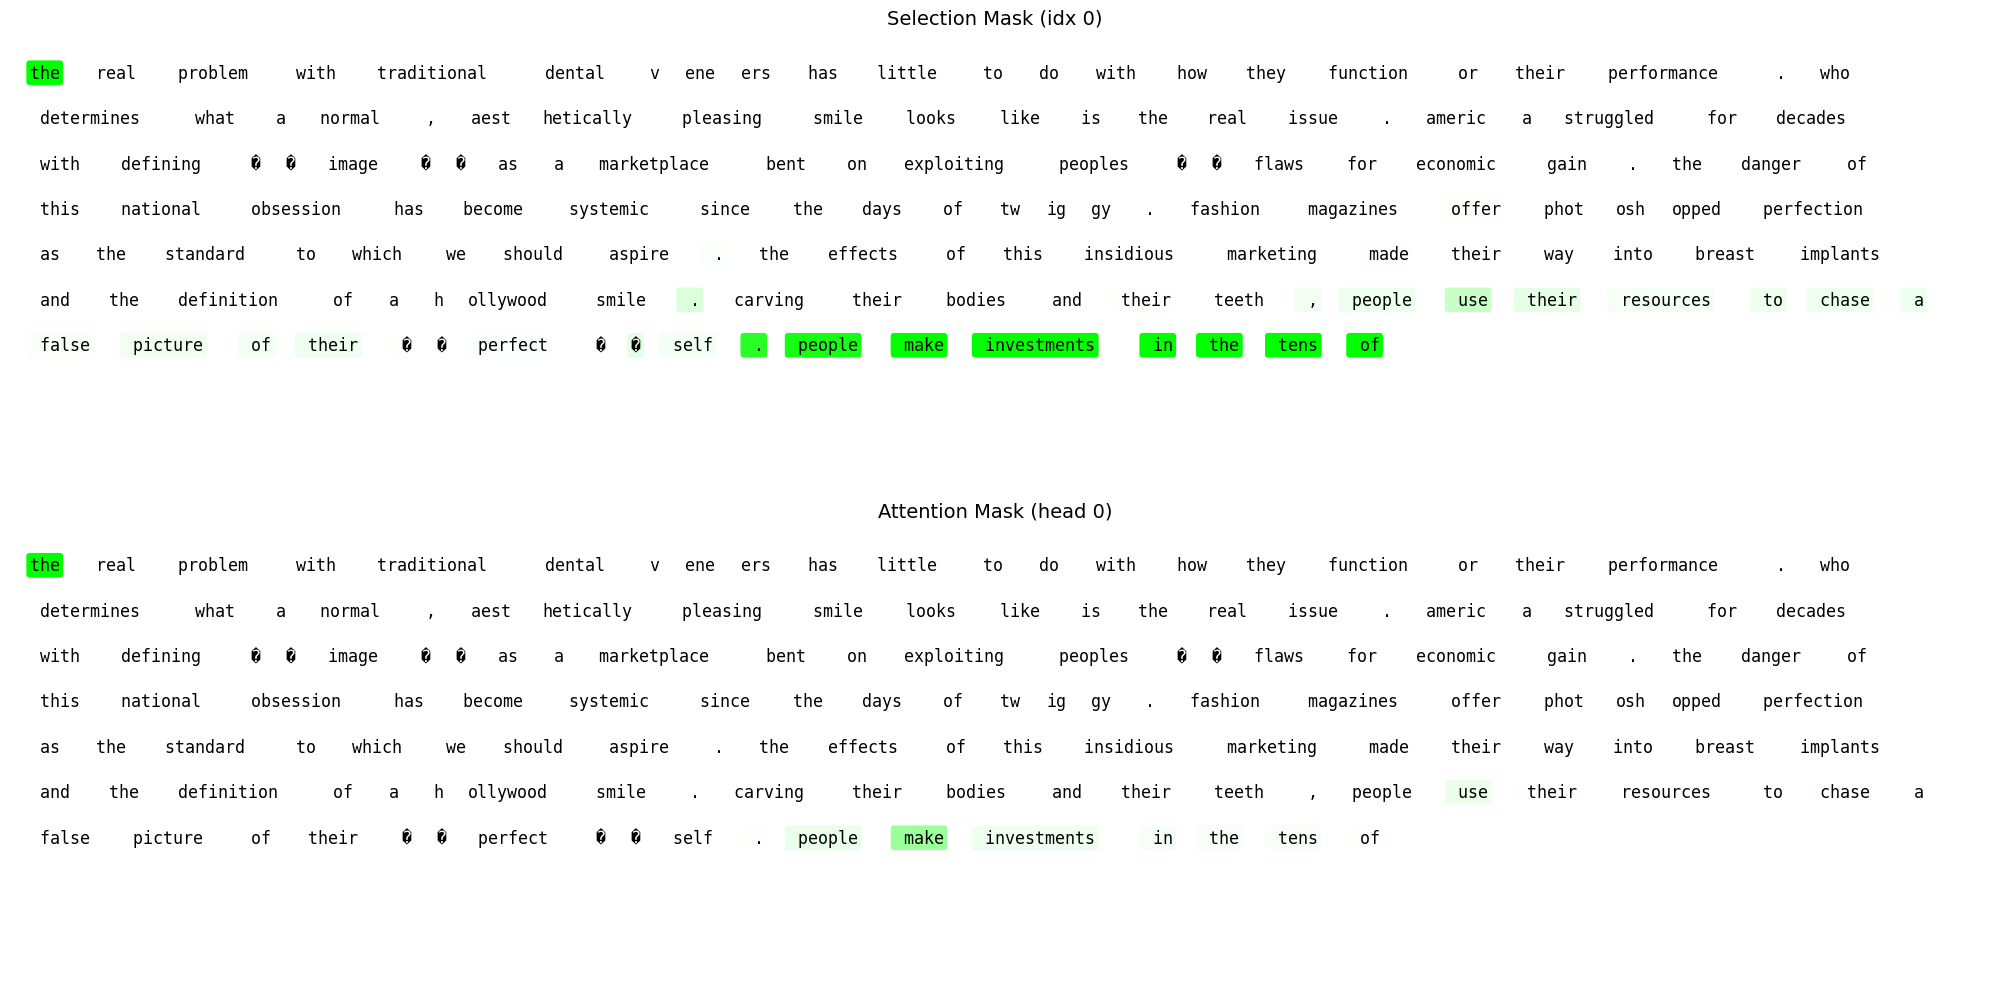

In [7]:
import textwrap
import matplotlib.pyplot as plt
import numpy as np
import math

length_to_show = 150

tokens = enc.encode(text)
text_per_token = enc.decode_batch([[i] for i in tokens[:length_to_show]])

ff_layer = 4
attn_head_idx = 0

# Get selection mask (idx 0) and attention mask (attn_head_idx)
selection_mask = ff_cache[ff_layer][0][0, 0, length_to_show-1]  # Always use idx 0
attn_mask = ff_cache[ff_layer][1][0, attn_head_idx, length_to_show-1]  # Use attn_head_idx

# Process selection mask: exp(-mask)
selection_mask_scores = np.exp(-selection_mask)

# Process attention mask: softmax(att - selection_mask)
att_minus_mask = attn_mask - selection_mask
att_scores = np.exp(att_minus_mask) / np.sum(np.exp(att_minus_mask))
# Normalize so row-wise max is 1
att_scores = att_scores / np.max(att_scores,axis=-1,keepdims=True)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Function to plot colored tokens
def plot_colored_tokens(ax, tokens, scores, title):
    ax.axis("off")
    ax.set_title(title, fontsize=14)
    
    # Starting normalized coordinates
    x, y = 0.01, 0.9
    line_height = 0.1
    space_width = 0.01
    
    for token, score in zip(tokens, scores):
        # Clamp score between 0 and 1
        score = 1 - score
        
        # Color mapping: green (low score) to white (high score)
        color = (score, 1, score)
        
        # Estimate token width
        token_width = 0.0125 / 2 * len(token)
        
        # Wrap to next line if needed
        if x + token_width > 0.98:
            x = 0.01
            y -= line_height
        
        # Draw token with colored background
        ax.text(x, y, token, transform=ax.transAxes, fontsize=12, fontfamily="monospace",
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))
        
        # Update position for next token
        x += token_width + space_width

# Plot selection mask (idx 0)
plot_colored_tokens(ax1, text_per_token, selection_mask_scores, "Selection Mask (idx 0)")

# Plot attention mask (attn_head_idx)
plot_colored_tokens(ax2, text_per_token, att_scores, f"Attention Mask (head {attn_head_idx})")

plt.tight_layout()
plt.show()
